In [1]:
import datetime

import numpy as np
import pandas as pd

from src.data_handler import CoinDataStore
from src.simple_wash_detector_utils import detect_wash_trades_nearest

In [2]:
store = CoinDataStore("AVAX", engine="fastparquet")
df_all_matched = store.load_all()
df_all_matched

,price,size,time,seller,buyer
0,19.521999,213.199997,2025-03-22 10:50:22.930512310,8,658
1,19.521999,1.000000,2025-03-22 10:50:23.731759790,19,658
2,19.525999,11.820000,2025-03-22 10:50:43.490273671,161,1260
3,19.525999,39.150002,2025-03-22 10:50:43.490273671,161,19500
4,19.525000,8.800000,2025-03-22 10:50:43.490273671,161,240
...,...,...,...,...,...
1478242,24.966999,1.210000,2025-07-27 08:44:33.762000000,8,1527
1478243,24.971001,308.359985,2025-07-27 08:44:59.437000000,161,5135
1478244,24.971001,203.639999,2025-07-27 08:44:59.437000000,892,5135
1478245,24.971001,11.940000,2025-07-27 08:45:07.130000000,19,170117


In [3]:
sells = df_all_matched[["seller", "time", "price", "size"]].rename(columns={"seller": "wallet_id"}).copy()
sells["is_ask"] = True

buys = df_all_matched[["buyer", "time", "price", "size"]].rename(columns={"buyer": "wallet_id"}).copy()
buys["is_ask"] = False

df_all = pd.concat([sells, buys], ignore_index=True)
df_all

,wallet_id,time,price,size,is_ask
0,8,2025-03-22 10:50:22.930512310,19.521999,213.199997,True
1,19,2025-03-22 10:50:23.731759790,19.521999,1.000000,True
2,161,2025-03-22 10:50:43.490273671,19.525999,11.820000,True
3,161,2025-03-22 10:50:43.490273671,19.525999,39.150002,True
4,161,2025-03-22 10:50:43.490273671,19.525000,8.800000,True
...,...,...,...,...,...
2956489,1527,2025-07-27 08:44:33.762000000,24.966999,1.210000,False
2956490,5135,2025-07-27 08:44:59.437000000,24.971001,308.359985,False
2956491,5135,2025-07-27 08:44:59.437000000,24.971001,203.639999,False
2956492,170117,2025-07-27 08:45:07.130000000,24.971001,11.940000,False


In [4]:
df_all["notional"] = df_all["price"] * df_all["size"]
df_all = df_all.groupby(["wallet_id", "time", "is_ask"]).agg(size=("size", "sum"), notional=("notional", "sum")).reset_index()
df_all["price"] = (df_all["notional"] / df_all["size"]).astype("float32")
df_all = df_all.drop("notional", axis=1)
df_all

,wallet_id,time,is_ask,size,price
0,1,2025-06-30 19:16:16.060,False,47.049999,18.014999
1,1,2025-06-30 19:16:46.011,False,47.049999,18.025000
2,1,2025-06-30 19:17:17.005,False,47.059998,18.030884
3,1,2025-06-30 19:17:46.024,False,47.049999,18.018999
4,1,2025-06-30 19:18:16.077,False,47.059998,18.011999
...,...,...,...,...,...
2265245,272404,2025-06-23 16:40:53.219,True,959.900024,16.377071
2265246,272404,2025-06-23 16:45:39.769,False,959.900024,16.470161
2265247,274311,2025-06-15 15:19:18.194,True,2.710000,19.183001
2265248,274311,2025-06-15 17:27:03.505,False,2.710000,19.049000


In [5]:
df_all[df_all["wallet_id"] == 1]

,wallet_id,time,is_ask,size,price
0,1,2025-06-30 19:16:16.060,False,47.049999,18.014999
1,1,2025-06-30 19:16:46.011,False,47.049999,18.025000
2,1,2025-06-30 19:17:17.005,False,47.059998,18.030884
3,1,2025-06-30 19:17:46.024,False,47.049999,18.018999
4,1,2025-06-30 19:18:16.077,False,47.059998,18.011999
...,...,...,...,...,...
64,1,2025-07-01 14:01:47.050,False,4.960000,17.407000
65,1,2025-07-01 14:02:17.006,False,4.970000,17.395000
66,1,2025-07-01 14:02:47.034,False,4.960000,17.407000
67,1,2025-07-01 14:03:17.025,False,4.970000,17.403000


In [6]:
df_all["time"] = pd.to_datetime(df_all["time"], utc=True)
df_all["date"] = pd.to_datetime(df_all["time"], utc=True).dt.date
df_all["hour"] = df_all.time.dt.hour
df_all["date_hour"] = df_all["date"].astype("str") + df_all["hour"].astype("str")

df_all["round_size"] = df_all["size"].map(lambda x: round(x, 2))
# Per-wallet aggregates
wallet_stats = (
    df_all
    .groupby("wallet_id")
    .agg(
        n_trades=("size", "count"),
        nunique_sizes=("round_size", "nunique"),
        total_volume=("size", "sum"),
        avg_size=("size", "mean"),
        std_size=("size", "std"),
        size_p01=("size", lambda x: np.percentile(x, 1)),
        size_p10=("size", lambda x: np.percentile(x, 10)),
        size_p50=("size", lambda x: np.percentile(x, 50)),
        size_p90=("size", lambda x: np.percentile(x, 90)),
        size_p99=("size", lambda x: np.percentile(x, 99)),
        first_trade=("time", "min"),
        last_trade=("time", "max"),
        unique_dates=("date", "nunique"),
        unique_date_hour=("date_hour", "nunique"),
    )
)
wallet_stats = wallet_stats.dropna()

wallet_stats["trades_per_day"] = wallet_stats["n_trades"] / wallet_stats["unique_dates"]
wallet_stats["total_volume"] = wallet_stats["total_volume"].map(lambda x: round(x, 3))


# Concentration
# Share of total volume per wallet
wallet_stats["volume_share"] = wallet_stats["total_volume"] / wallet_stats["total_volume"].sum()
wallet_stats["volume_share"] = wallet_stats["volume_share"].map(lambda x: round(x, 3))

wallet_stats

,n_trades,nunique_sizes,total_volume,avg_size,std_size,size_p01,size_p10,size_p50,size_p90,size_p99,first_trade,last_trade,unique_dates,unique_date_hour,trades_per_day,volume_share
wallet_id,,,,,,,,,,,,,,,,
1,69,5,4800.000,69.565216,285.302948,4.960000,4.960000,47.049999,47.060001,800.000061,2025-06-30 19:16:16.060000+00:00,2025-07-01 19:47:22.660000+00:00,2,4,34.500000,0.000
3,3937,3222,711997.875,180.847824,273.010529,0.560000,3.926000,84.989998,475.785980,1323.202148,2025-05-21 14:47:25.050388950+00:00,2025-07-27 06:14:00.468000+00:00,66,711,59.651515,0.004
5,2156,1251,101469.781,47.063908,51.910038,1.529000,3.000000,23.395000,142.975006,170.933502,2025-03-22 10:59:45.086918079+00:00,2025-07-27 08:12:39.634000+00:00,67,476,32.179104,0.001
6,3275,1653,160148.188,48.900211,56.465569,2.000000,3.000000,19.040001,152.991989,181.770004,2025-03-22 20:19:39.015273065+00:00,2025-07-14 05:57:35.749000+00:00,97,635,33.762887,0.001
7,5523,2245,216830.234,39.259502,51.657661,2.052200,3.000000,12.320000,138.825958,171.993408,2025-03-22 14:57:02.904875645+00:00,2025-07-27 05:03:12.884000+00:00,121,1125,45.644628,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271551,2,1,72.260,36.129997,0.000003,36.129997,36.129997,36.129997,36.130001,36.130001,2025-07-18 05:51:15.729000+00:00,2025-07-18 15:19:15.605000+00:00,1,2,2.000000,0.000
271895,12,10,637.720,53.143337,18.827892,31.775200,35.654999,50.514999,75.479996,92.380806,2025-06-22 06:15:44.332000+00:00,2025-06-23 11:27:30.520000+00:00,2,7,6.000000,0.000
272337,2,1,119.320,59.660004,0.000003,59.660000,59.660000,59.660004,59.660004,59.660004,2025-06-22 09:22:01.823000+00:00,2025-06-23 06:18:48.518000+00:00,2,2,1.000000,0.000


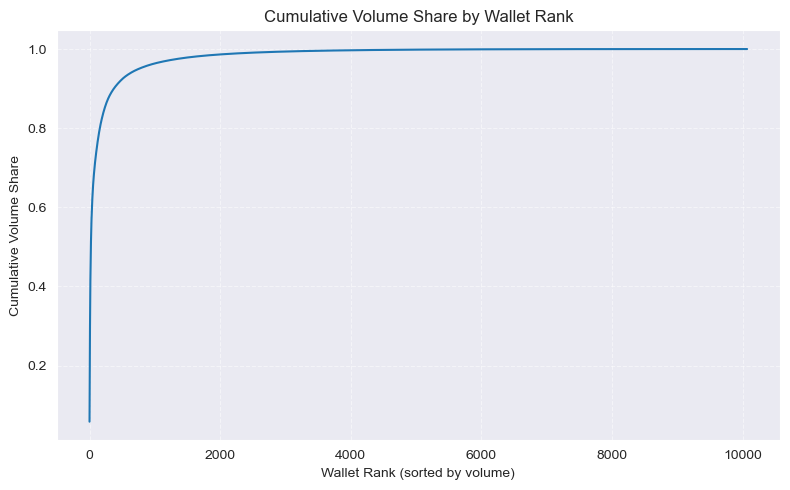

In [7]:
# Plots
import matplotlib.pyplot as plt

# Wallet concentration plot (Pareto-style)
plt.figure(figsize=(8,5))
wallet_stats_sorted = wallet_stats.sort_values("total_volume", ascending=False)
wallet_stats_sorted["cum_volume_share"] = wallet_stats_sorted["total_volume"].cumsum() / wallet_stats_sorted["total_volume"].sum()
wallet_stats_sorted["cum_volume_share"].reset_index(drop=True).plot()
plt.title("Cumulative Volume Share by Wallet Rank")
plt.xlabel("Wallet Rank (sorted by volume)")
plt.ylabel("Cumulative Volume Share")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [8]:
wallet_stats.sort_values("total_volume", ascending=False)

,n_trades,nunique_sizes,total_volume,avg_size,std_size,size_p01,size_p10,size_p50,size_p90,size_p99,first_trade,last_trade,unique_dates,unique_date_hour,trades_per_day,volume_share
wallet_id,,,,,,,,,,,,,,,,
161,139051,27262,9530737.00,68.541306,143.107941,0.42,0.760000,11.070000,208.220001,644.520020,2025-03-22 10:50:43.490273671+00:00,2025-07-27 08:44:59.437000+00:00,128,3015,1086.335938,0.058
22,79578,22622,6973105.00,87.626038,140.404144,0.46,1.680000,51.680000,206.412964,613.329346,2025-03-22 10:59:38.449109120+00:00,2025-07-27 08:40:50.029000+00:00,128,2821,621.703125,0.043
13372,1067,663,6594980.50,6180.862793,10054.875000,1.00,12.077998,286.709991,20000.000000,49775.980469,2025-03-22 20:13:34.670003528+00:00,2025-07-10 00:47:01.426000+00:00,48,124,22.229167,0.040
534,39258,18798,5635417.00,143.548248,280.851501,0.47,1.100000,49.465000,377.969025,1390.262573,2025-03-22 10:52:22.010294410+00:00,2025-07-27 08:42:49.339000+00:00,128,2971,306.703125,0.034
892,76675,19935,5206099.50,67.898262,136.579926,0.44,0.790000,12.800000,208.430069,682.580505,2025-03-22 10:50:50.769304873+00:00,2025-07-27 08:44:59.437000+00:00,128,2969,599.023438,0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169312,3,2,0.04,0.013333,0.005774,0.01,0.010000,0.010000,0.018000,0.019800,2025-07-25 07:31:02.165000+00:00,2025-07-25 08:10:00.793000+00:00,1,2,3.000000,0.000
21991,2,1,0.02,0.010000,0.000000,0.01,0.010000,0.010000,0.010000,0.010000,2025-03-25 07:53:53.460984844+00:00,2025-03-25 10:18:32.079100160+00:00,1,2,2.000000,0.000
213204,2,1,0.02,0.010000,0.000000,0.01,0.010000,0.010000,0.010000,0.010000,2025-06-01 05:36:30.589000+00:00,2025-06-01 12:35:35.194000+00:00,1,2,2.000000,0.000


In [9]:
wallet_stats[wallet_stats["trades_per_day"] > 100]["volume_share"].sum()

np.float64(0.474)

In [10]:
interaction_df =(
    pd.concat([
        df_all_matched[["seller", "buyer"]].rename({"buyer": "wallet_1", "seller": "wallet_2"}, axis=1),
        df_all_matched[["seller", "buyer"]].rename({"seller": "wallet_1", "buyer": "wallet_2"}, axis=1)
    ])
)
interaction_df = interaction_df.groupby("wallet_1")["wallet_2"].nunique().reset_index().rename({"wallet_1": "wallet_id", "wallet_2": "wallet_interactions"}, axis=1)
interaction_df

,wallet_id,wallet_interactions
0,1,23
1,3,548
2,5,352
3,6,330
4,7,519
...,...,...
10630,271895,10
10631,272337,3
10632,272404,15
10633,274311,2


In [11]:
wallet_stats = wallet_stats.reset_index().merge(interaction_df, on="wallet_id", how="left")

# Profit calculating

In [12]:
import pandas as pd

def calculate_realized_pnl(df_all: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates realized profit per wallet with both long and short handling (FIFO).

    Args:
        df_all: DataFrame with columns ['wallet_id', 'time', 'price', 'size', 'is_ask']

    Returns:
        DataFrame with columns ['wallet_id', 'realized_profit']
    """
    df = df_all.sort_values(['wallet_id', 'time']).copy()
    profits = {}

    for wallet, trades in df.groupby('wallet_id'):
        longs = []   # [(size, price)]
        shorts = []  # [(size, price)]
        profit = 0.0

        for _, row in trades.iterrows():
            size = row['size']
            price = row['price']

            if not row['is_ask']:
                # BUY
                remaining = size
                # Close existing shorts first
                while remaining > 0 and shorts:
                    short_size, short_price = shorts[0]
                    matched = min(remaining, short_size)
                    profit += (short_price - price) * matched  # close short
                    short_size -= matched
                    remaining -= matched
                    if short_size == 0:
                        shorts.pop(0)
                    else:
                        shorts[0][0] = short_size
                # If still have remaining buy size, open long
                if remaining > 0:
                    longs.append([remaining, price])

            else:
                # SELL
                remaining = size
                # Close existing longs first
                while remaining > 0 and longs:
                    long_size, long_price = longs[0]
                    matched = min(remaining, long_size)
                    profit += (price - long_price) * matched  # close long
                    long_size -= matched
                    remaining -= matched
                    if long_size == 0:
                        longs.pop(0)
                    else:
                        longs[0][0] = long_size
                # If still have remaining sell size, open short
                if remaining > 0:
                    shorts.append([remaining, price])

        profits[wallet] = profit

    return pd.DataFrame(list(profits.items()), columns=['wallet_id', 'realized_profit'])


In [13]:
wallet_realized_profits = calculate_realized_pnl(df_all)
wallet_realized_profits

,wallet_id,realized_profit
0,1,-2267.187876
1,3,5735.945456
2,5,286.573061
3,6,-988.369196
4,7,2080.928196
...,...,...
10630,271895,88.391194
10631,272337,4.533945
10632,272404,-89.357148
10633,274311,0.363142


In [14]:
wallet_stats = pd.merge(
    wallet_stats,
    wallet_realized_profits,
    on='wallet_id',
    how='left'
)

In [15]:
wallet_stats.sort_values("total_volume", ascending=False).head(15)

,wallet_id,n_trades,nunique_sizes,total_volume,avg_size,std_size,size_p01,size_p10,size_p50,size_p90,size_p99,first_trade,last_trade,unique_dates,unique_date_hour,trades_per_day,volume_share,wallet_interactions,realized_profit
58,161,139051,27262,9530737.00,68.541306,143.107941,0.4200,0.760000,11.070000,208.220001,644.520020,2025-03-22 10:50:43.490273671+00:00,2025-07-27 08:44:59.437000+00:00,128,3015,1086.335938,0.058,6445,15999.614909
16,22,79578,22622,6973105.00,87.626038,140.404144,0.4600,1.680000,51.680000,206.412964,613.329346,2025-03-22 10:59:38.449109120+00:00,2025-07-27 08:40:50.029000+00:00,128,2821,621.703125,0.043,4384,72056.734755
1939,13372,1067,663,6594980.50,6180.862793,10054.875000,1.0000,12.077998,286.709991,20000.000000,49775.980469,2025-03-22 20:13:34.670003528+00:00,2025-07-10 00:47:01.426000+00:00,48,124,22.229167,0.040,260,265433.690781
134,534,39258,18798,5635417.00,143.548248,280.851501,0.4700,1.100000,49.465000,377.969025,1390.262573,2025-03-22 10:52:22.010294410+00:00,2025-07-27 08:42:49.339000+00:00,128,2971,306.703125,0.034,3580,253447.596216
212,892,76675,19935,5206099.50,67.898262,136.579926,0.4400,0.790000,12.800000,208.430069,682.580505,2025-03-22 10:50:50.769304873+00:00,2025-07-27 08:44:59.437000+00:00,128,2969,599.023438,0.032,4901,22243.953758
127,480,29159,15192,5008946.00,171.780441,334.470093,0.4600,0.930000,40.369999,464.819672,1669.534546,2025-03-22 10:59:44.856651452+00:00,2025-07-27 08:12:40.521000+00:00,125,2640,233.272000,0.031,2974,71488.976770
387,1621,25035,11133,4919995.50,196.524689,971.533264,0.5200,1.490000,38.770000,282.895996,4126.150879,2025-03-22 20:13:34.670003528+00:00,2025-07-23 19:34:01.899000+00:00,106,421,236.179245,0.030,1207,73863.714173
14,19,189043,15435,4486441.50,23.732386,42.587444,0.4700,0.830000,10.000000,53.630001,203.330002,2025-03-22 10:50:23.731759790+00:00,2025-07-27 08:45:47.161000+00:00,128,3046,1476.898438,0.027,6453,63102.256114
5,8,170994,15268,4276013.00,25.006802,44.284374,0.4900,0.840000,11.140000,57.169998,210.770172,2025-03-22 10:50:22.930512310+00:00,2025-07-27 08:44:33.762000+00:00,128,3047,1335.890625,0.026,6014,-34561.040387
437,1844,3413,2263,4046746.00,1185.685913,1133.243164,0.7200,14.000000,978.119995,2818.850098,3557.330078,2025-03-22 20:13:34.670003528+00:00,2025-07-26 21:00:34.133000+00:00,123,1024,27.747967,0.025,745,140319.784529


In [16]:
5505

5505

# Benfords law for each wallet

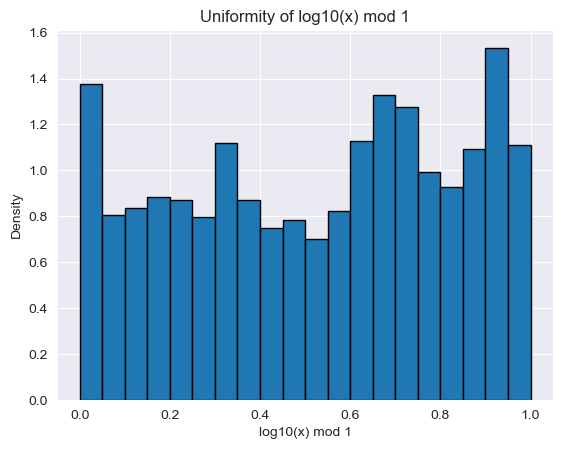

Kolmogorov–Smirnov test: statistic=0.0728, p-value=0.0000


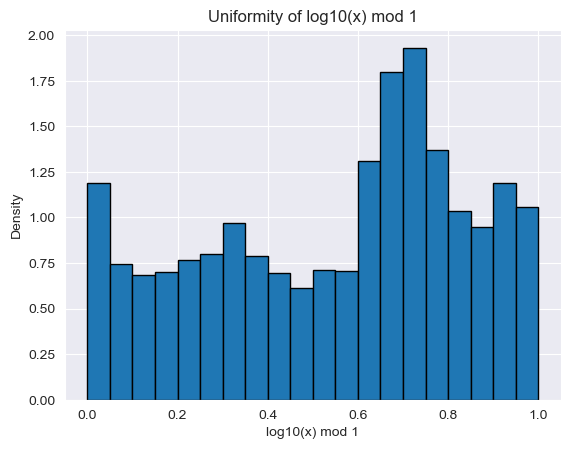

Kolmogorov–Smirnov test: statistic=0.1326, p-value=0.0000


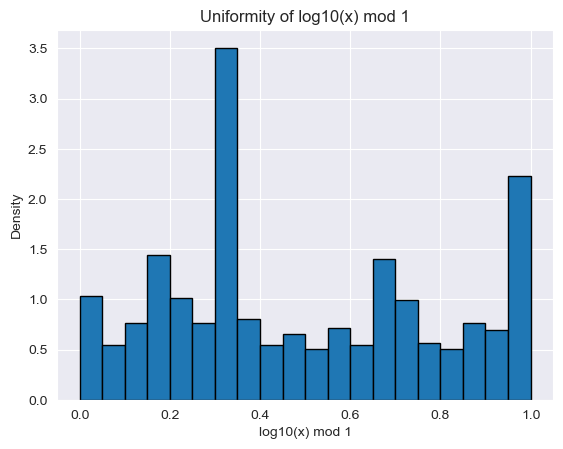

Kolmogorov–Smirnov test: statistic=0.1142, p-value=0.0000


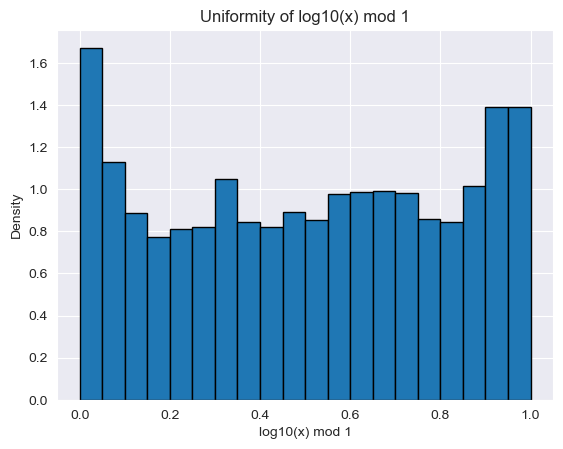

Kolmogorov–Smirnov test: statistic=0.0445, p-value=0.0000


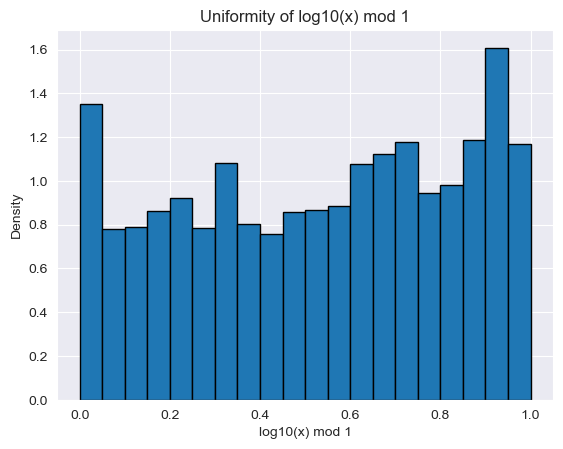

Kolmogorov–Smirnov test: statistic=0.0666, p-value=0.0000


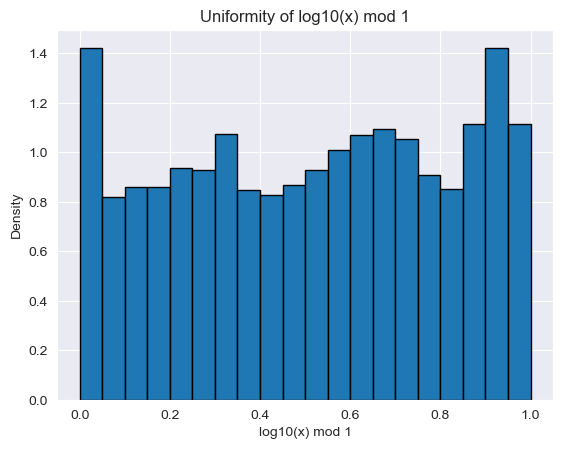

Kolmogorov–Smirnov test: statistic=0.0377, p-value=0.0000


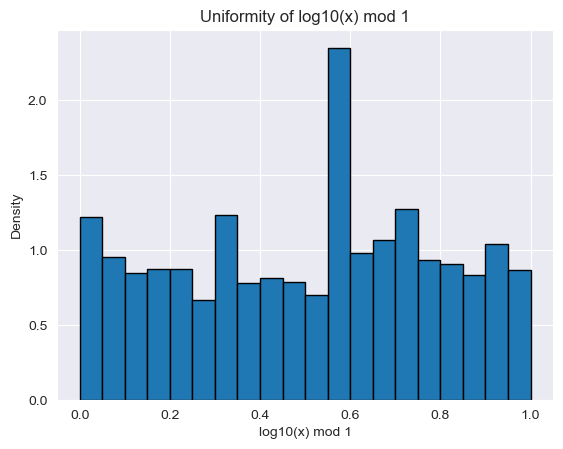

Kolmogorov–Smirnov test: statistic=0.0741, p-value=0.0000


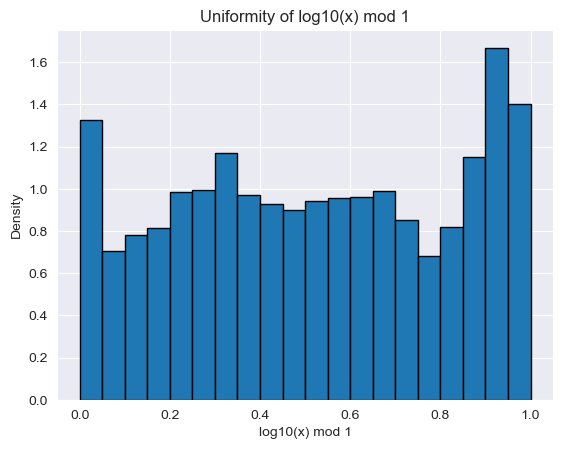

Kolmogorov–Smirnov test: statistic=0.0640, p-value=0.0000


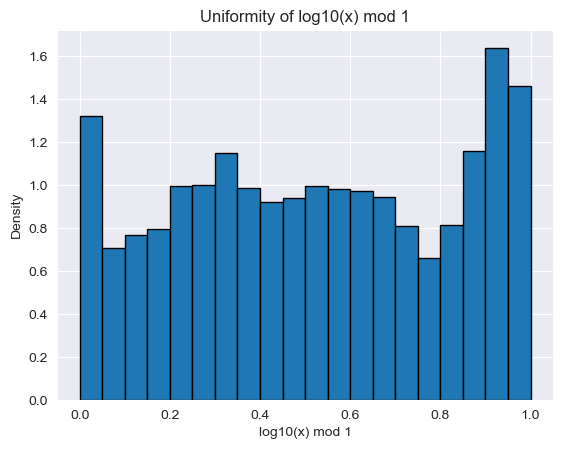

Kolmogorov–Smirnov test: statistic=0.0649, p-value=0.0000


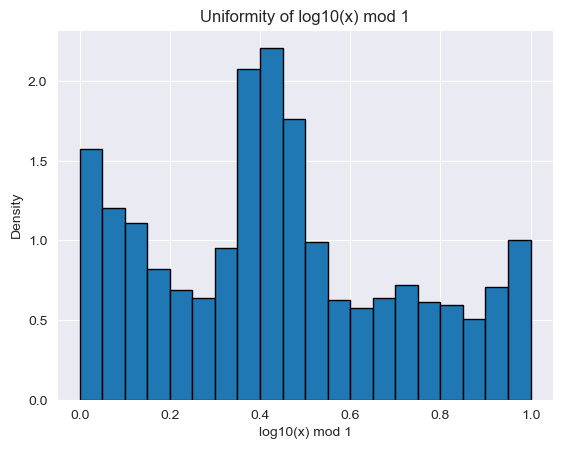

Kolmogorov–Smirnov test: statistic=0.1579, p-value=0.0000


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest

wallet_to_check = 13372
for wallet_to_check in wallet_stats.sort_values("total_volume", ascending=False)["wallet_id"].iloc[:10].values:
    # Ensure only positive values
    sizes = df_all[df_all["wallet_id"] == wallet_to_check]["size"]
    sizes = sizes[sizes > 0]

    logs = np.log10(sizes)
    frac = logs % 1

    plt.hist(frac, bins=20, edgecolor='black', density=True)
    plt.xlabel('log10(x) mod 1')
    plt.ylabel('Density')
    plt.title('Uniformity of log10(x) mod 1')
    plt.show()

    stat, p_value = kstest(frac, 'uniform')
    print(f"Kolmogorov–Smirnov test: statistic={stat:.4f}, p-value={p_value:.4f}")

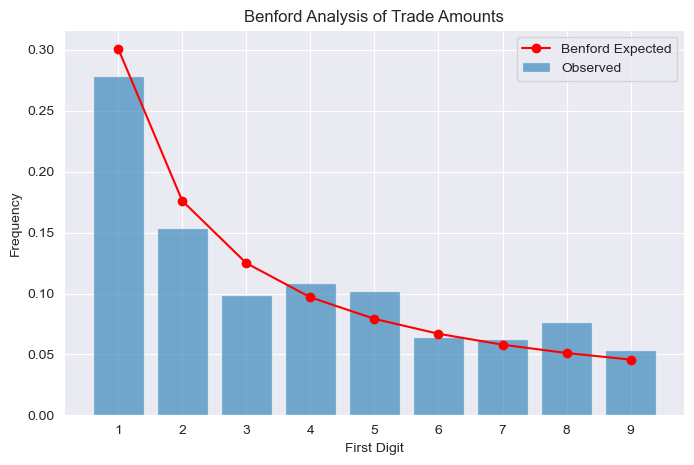

Chi-square statistic: 4571.785041169662
p-value: 0.0


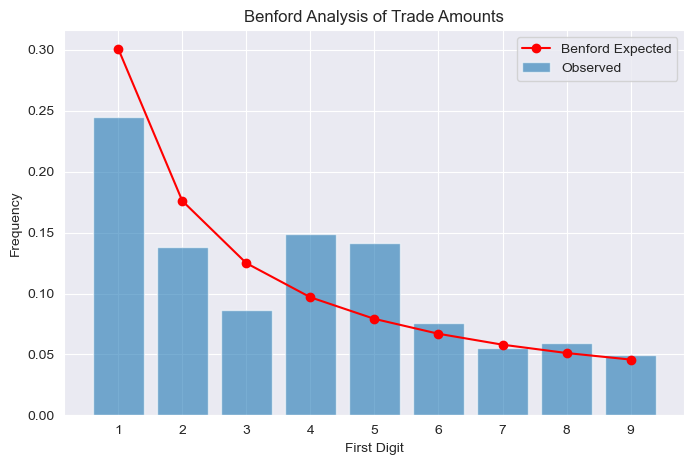

Chi-square statistic: 8788.906864428416
p-value: 0.0


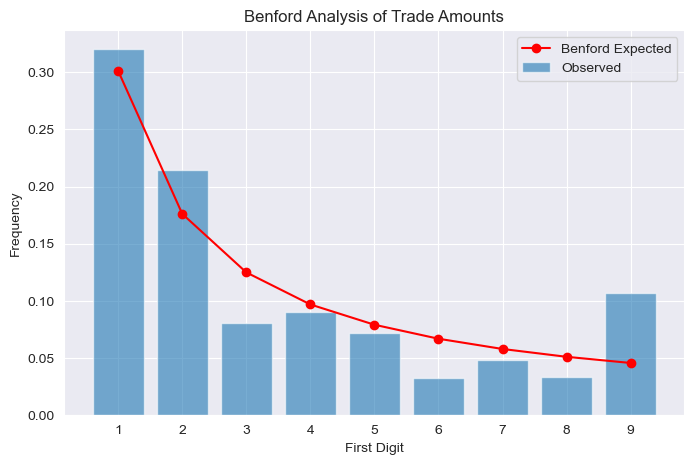

Chi-square statistic: 141.81587450542702
p-value: 9.942774810494748e-27


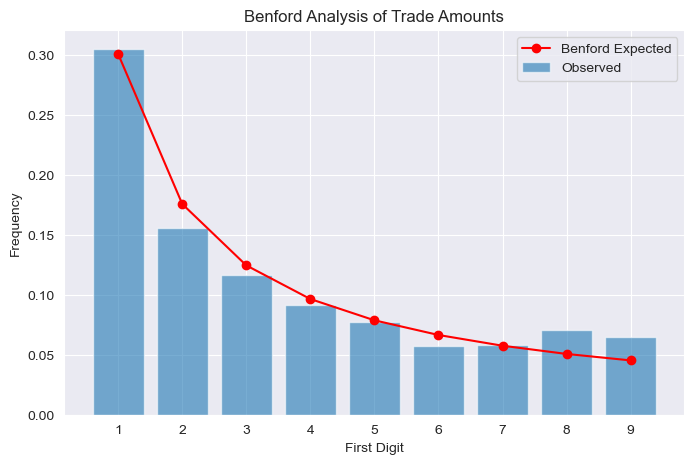

Chi-square statistic: 791.0791763685922
p-value: 1.722091329751153e-165


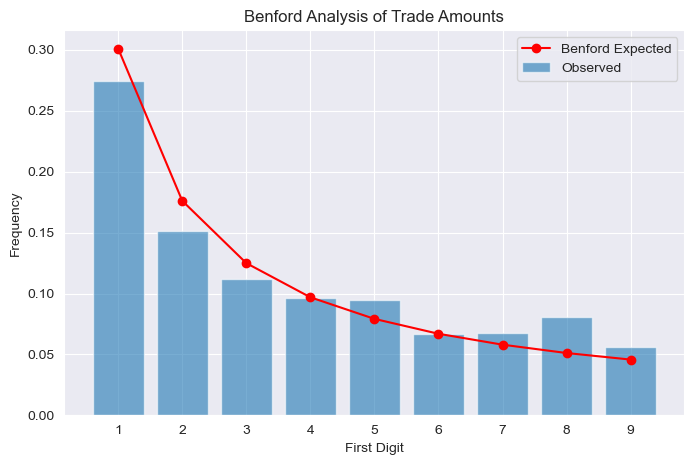

Chi-square statistic: 2368.577681760391
p-value: 0.0


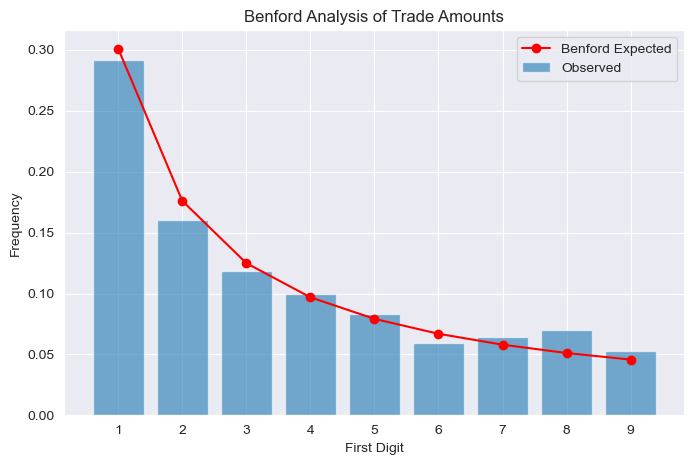

Chi-square statistic: 356.4810428740983
p-value: 3.7438904885915343e-72


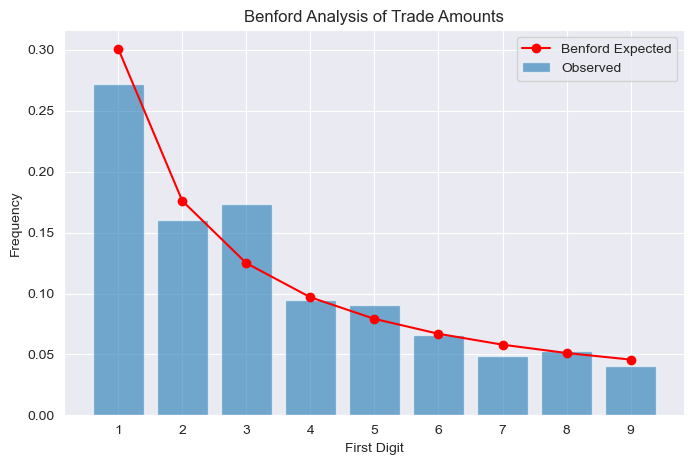

Chi-square statistic: 675.972193109883
p-value: 1.0639202480928726e-140


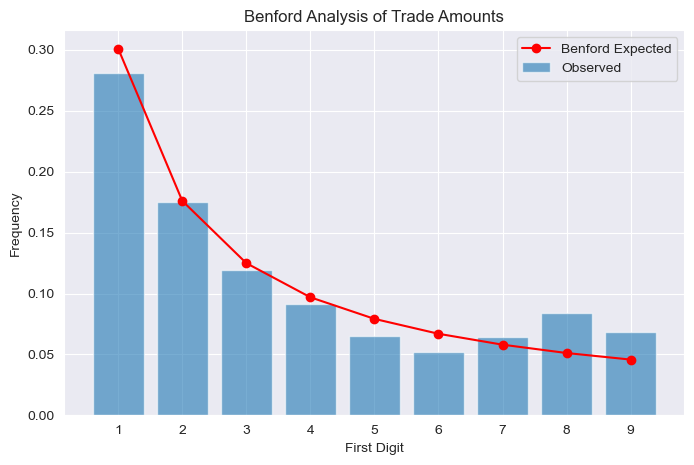

Chi-square statistic: 7676.951170252827
p-value: 0.0


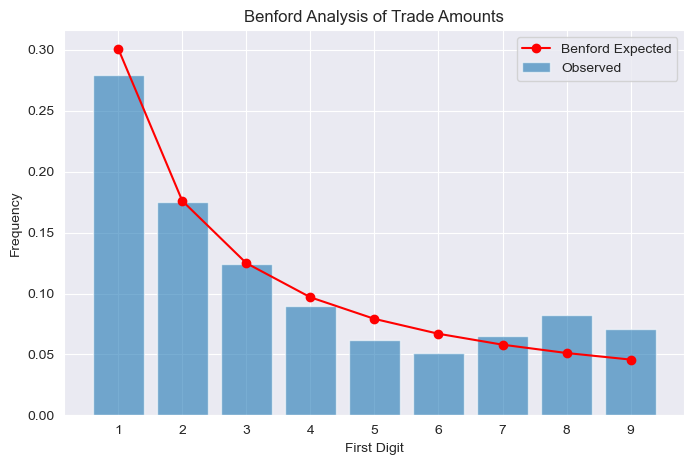

Chi-square statistic: 7423.839884648523
p-value: 0.0


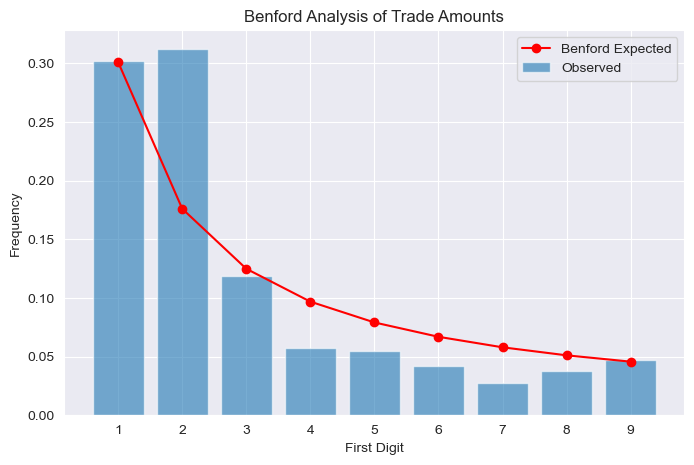

Chi-square statistic: 539.7539015425317
p-value: 2.0611623115274875e-111


In [18]:
from collections import Counter

wallet_to_check = 13372
for wallet_to_check in wallet_stats.sort_values("total_volume", ascending=False)["wallet_id"].iloc[:10].values:

    trade_amounts = df_all[df_all["wallet_id"] == wallet_to_check]["size"].astype(str)  # convert to string

    def first_digit(x):
        for c in x:
            if c.isdigit() and c != '0':
                return int(c)
        return None

    first_digits = trade_amounts.apply(first_digit)
    first_digits = first_digits.dropna()

    digit_counts = Counter(first_digits)
    total = sum(digit_counts.values())

    observed_freq = {d: digit_counts.get(d, 0) / total for d in range(1, 10)}

    expected_freq = {d: np.log10(1 + 1/d) for d in range(1, 10)}

    digits = range(1, 10)
    obs = [observed_freq[d] for d in digits]
    exp = [expected_freq[d] for d in digits]

    plt.figure(figsize=(8,5))
    plt.bar(digits, obs, alpha=0.6, label='Observed')
    plt.plot(digits, exp, 'ro-', label='Benford Expected')
    plt.xlabel('First Digit')
    plt.ylabel('Frequency')
    plt.title('Benford Analysis of Trade Amounts')
    plt.xticks(digits)
    plt.legend()
    plt.show()

    from scipy.stats import chisquare

    chi_stat, p_value = chisquare(f_obs=[digit_counts.get(d,0) for d in digits],
                                  f_exp=[expected_freq[d]*total for d in digits])

    print("Chi-square statistic:", chi_stat)
    print("p-value:", p_value)


In [19]:
df_all = df_all.sort_values("time")

In [20]:
df_all[df_all["wallet_id"] == 22].iloc[:25]

,wallet_id,time,is_ask,size,price,date,hour,date_hour,round_size
409303,22,2025-03-22 10:59:38.449109120+00:00,False,42.500000,19.565001,2025-03-22,10,2025-03-2210,42.50
409304,22,2025-03-22 10:59:43.669299844+00:00,False,9.600000,19.565001,2025-03-22,10,2025-03-2210,9.60
409305,22,2025-03-22 10:59:43.869763537+00:00,False,41.389999,19.565001,2025-03-22,10,2025-03-2210,41.39
409306,22,2025-03-22 10:59:44.856651452+00:00,False,50.990002,19.565001,2025-03-22,10,2025-03-2210,50.99
409307,22,2025-03-22 10:59:45.086918079+00:00,False,50.990002,19.556999,2025-03-22,10,2025-03-2210,50.99
409308,22,2025-03-22 10:59:50.140863035+00:00,False,30.420000,19.556999,2025-03-22,10,2025-03-2210,30.42
409309,22,2025-03-22 11:08:13.993171661+00:00,False,46.279999,19.507999,2025-03-22,11,2025-03-2211,46.28
409310,22,2025-03-22 11:08:14.106266595+00:00,False,4.710000,19.507999,2025-03-22,11,2025-03-2211,4.71
409311,22,2025-03-22 13:16:11.417371851+00:00,False,13.540000,19.406000,2025-03-22,13,2025-03-2213,13.54
409312,22,2025-03-22 13:22:52.120223165+00:00,False,1.000000,19.365000,2025-03-22,13,2025-03-2213,1.00


In [21]:
df_all[(df_all["wallet_id"] == 22) & (df_all["is_ask"])].iloc[:5]["size"].sum(), df_all[(df_all["wallet_id"] == 22) & (~df_all["is_ask"])].iloc[:16]["size"].sum()

(np.float32(968.81), np.float32(504.22))

# clusterization

In [22]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


def prepare_data(df,
                 wallet_col='wallet',
                 ts_col='timestamp',
                 side_col='side',
                 size_col='size',
                 price_col='price'):
    # Copy and convert types
    df = df.copy()
    # ensure timestamp is datetime
    df[ts_col] = pd.to_datetime(df[ts_col])
    # canonicalize side
    df[side_col] = df[side_col].astype(str).str.lower()
    return df

def build_wallet_features(df,
                          wallet_col='wallet',
                          ts_col='timestamp',
                          side_col='side',
                          size_col='size',
                          price_col='price'):
    # groupby wallet and compute features
    g = df.groupby(wallet_col)

    # Basic counts and volume
    features = pd.DataFrame({
        'n_trades': g.size(),
        'n_days_active': g[ts_col].apply(lambda x: x.dt.date.nunique()),
        'total_volume': g[size_col].sum(),
        'mean_size': g[size_col].mean(),
        'median_size': g[size_col].median(),
        'std_size': g[size_col].std().fillna(0),
        'min_size': g[size_col].min(),
        'max_size': g[size_col].max(),
    })

    # buy / sell counts and ratio
    buy_mask = df[side_col].isin(['buy', 'b', '1', 'true', 't'])
    sell_mask = df[side_col].isin(['sell', 's', '-1', 'false', 'f'])
    buy_counts = df[buy_mask].groupby(wallet_col).size()
    sell_counts = df[sell_mask].groupby(wallet_col).size()
    features['n_buy'] = buy_counts
    features['n_sell'] = sell_counts
    features['n_buy'] = features['n_buy'].fillna(0)
    features['n_sell'] = features['n_sell'].fillna(0)
    # buy-to-sell ratio (add small epsilon to denom)
    features['buy_sell_ratio'] = features['n_buy'] / (features['n_sell'] + 1e-9)

    # activity cadence: average time between trades (in minutes)
    def avg_inter_trade_minutes(ts):
        if len(ts) <= 1:
            return np.nan
        diffs = ts.sort_values().diff().dt.total_seconds().dropna() / 60.0
        return diffs.mean()
    features['avg_intertrade_min'] = g[ts_col].apply(avg_inter_trade_minutes)

    # time-of-day behavior: fraction of trades in active hours, hour entropy
    def hour_stats(ts):
        hrs = ts.dt.hour
        hist = np.bincount(hrs, minlength=24)
        probs = hist / hist.sum() if hist.sum() > 0 else np.zeros(24)
        # entropy of hour distribution as a measure of spread (higher => spread across day)
        ent = -np.sum([p*np.log2(p) for p in probs if p>0])
        # fraction in (9-17) local hours as "daytime trading"
        daytime_frac = probs[9:18].sum()
        peak_hour = int(np.argmax(probs)) if hist.sum()>0 else np.nan
        return pd.Series({'hour_entropy': ent, 'daytime_frac': daytime_frac, 'peak_hour': peak_hour})
    hour_df = g[ts_col].apply(hour_stats).unstack().fillna(0)
    # apply returns MultiIndex; reformat:
    hour_df = hour_df.apply(lambda x: pd.Series(x), axis=1)
    features = features.join(hour_df)

    # Price-based features (if price present)
    if price_col in df.columns:
        features['mean_price'] = g[price_col].mean()
        features['std_price'] = g[price_col].std().fillna(0)
    else:
        features['mean_price'] = np.nan
        features['std_price'] = np.nan

    # derived features
    features['trades_per_active_day'] = features['n_trades'] / (features['n_days_active'] + 1e-9)
    # fill inf / NaN
    features = features.replace([np.inf, -np.inf], np.nan)
    features = features.fillna(0)

    return features

def scale_and_reduce(X, n_components=2):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    pca = PCA(n_components=n_components, random_state=42)
    Xp = pca.fit_transform(Xs)
    return Xs, Xp, scaler, pca

def run_kmeans(Xs, n_clusters=4, random_state=42):
    km = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=20)
    labels = km.fit_predict(Xs)
    return km, labels

def run_dbscan(Xs, eps=0.5, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(Xs)
    return db, labels

def cluster_summary(features_df, labels, label_name='cluster'):
    dfc = features_df.copy()
    dfc[label_name] = labels
    summary = dfc.groupby(label_name).agg(['count','mean','median']).transpose()
    return dfc, summary

def plot_pca(Xp, labels, title='PCA scatter of wallets', figsize=(8,6)):
    plt.figure(figsize=figsize)
    unique_labels = np.unique(labels)
    palette = plt.cm.get_cmap('tab10', len(unique_labels))
    for i, lab in enumerate(unique_labels):
        mask = labels == lab
        label_text = f'cluster {lab}' if lab != -1 else 'noise'
        plt.scatter(Xp[mask,0], Xp[mask,1], s=10, label=label_text, alpha=0.7)
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title(title)
    plt.legend(markerscale=2, fontsize=8)
    plt.grid(alpha=0.2)
    plt.show()

def radar_plot_centroids(features, labels, n_top_features=6):
    import math
    df = features.copy()
    df['cluster'] = labels
    centroids = df.groupby('cluster').median()
    # choose top features by variance across centroids (to plot distinguishing features)
    feat_vars = centroids.var(axis=0).sort_values(ascending=False)
    chosen = feat_vars.index[:n_top_features].tolist()
    # prepare radar
    N = len(chosen)
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]  # close the circle
    fig, axes = plt.subplots(1, len(centroids), subplot_kw=dict(polar=True), figsize=(3*len(centroids), 4))
    if len(centroids) == 1:
        axes = [axes]
    for ax, (cluster_label, row) in zip(axes, centroids.iterrows()):
        values = row[chosen].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2)
        ax.fill(angles, values, alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(chosen, fontsize=9)
        ax.set_title(f'cluster {cluster_label}', fontsize=10)
    plt.suptitle('Median feature profile per cluster (radar)', y=1.05)
    plt.tight_layout()
    plt.show()

# -------------------------
# Main pipeline function
# -------------------------
def segment_wallets(df,
                    wallet_col='wallet',
                    ts_col='timestamp',
                    side_col='side',
                    size_col='size',
                    price_col='price',
                    kmeans_k=4,
                    dbscan_eps=0.6,
                    dbscan_min_samples=5):
    df = prepare_data(df, wallet_col, ts_col, side_col, size_col, price_col)
    features = build_wallet_features(df, wallet_col, ts_col, side_col, size_col, price_col)

    # Choose features to cluster on (drop identifiers and sparse features if desired)
    chosen_features = [
        'n_trades', 'total_volume', 'mean_size', 'std_size', 'trades_per_active_day',
        'buy_sell_ratio', 'avg_intertrade_min', 'hour_entropy', 'daytime_frac'
    ]
    # include price stats if present and non-all-zero
    if 'mean_price' in features.columns and features['mean_price'].abs().sum() > 0:
        chosen_features += ['mean_price','std_price']

    # ensure features exist
    chosen_features = [f for f in chosen_features if f in features.columns]

    X = features[chosen_features].copy()
    # Impute missing values (e.g. avg_intertrade_min may be NaN if only 1 trade)
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), index=X.index, columns=X.columns)

    # scale & reduce for visualization
    Xs, Xp, scaler, pca = scale_and_reduce(X_imputed, n_components=2)

    # KMeans
    km, km_labels = run_kmeans(Xs, n_clusters=kmeans_k)
    km_sil = silhouette_score(Xs, km_labels) if len(set(km_labels)) > 1 else np.nan
    print(f'KMeans k={kmeans_k} silhouette score: {km_sil:.4f}')

    # DBSCAN
    db, db_labels = run_dbscan(Xs, eps=dbscan_eps, min_samples=dbscan_min_samples)
    db_unique = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    db_sil = silhouette_score(Xs[db_labels != -1], db_labels[db_labels != -1]) if db_unique > 1 else np.nan
    print(f'DBSCAN clusters (excluding noise): {db_unique}, silhouette (non-noise): {db_sil}')

    # Summaries
    km_wallets, km_summary = cluster_summary(features, km_labels, label_name='kmeans_cluster')
    db_wallets, db_summary = cluster_summary(features, db_labels, label_name='dbscan_cluster')

    print('\nKMeans cluster counts:')
    print(km_wallets['kmeans_cluster'].value_counts())
    print('\nDBSCAN cluster counts:')
    print(db_wallets['dbscan_cluster'].value_counts())

    # Visualize
    plot_pca(Xp, km_labels, title=f'PCA scatter (KMeans k={kmeans_k})')
    plot_pca(Xp, db_labels, title=f'PCA scatter (DBSCAN eps={dbscan_eps})')

    # Radar chart for cluster medians (KMeans)
    radar_plot_centroids(features[chosen_features], km_labels, n_top_features=min(6, len(chosen_features)))

    # return results and artifacts
    out = {
        'features': features,
        'chosen_features': chosen_features,
        'X_imputed': X_imputed,
        'scaler': scaler,
        'pca': pca,
        'pca_coords': pd.DataFrame(Xp, index=features.index, columns=['PC1','PC2']),
        'kmeans': {'model': km, 'labels': pd.Series(km_labels, index=features.index)},
        'dbscan': {'model': db, 'labels': pd.Series(db_labels, index=features.index)},
        'kmeans_summary': km_summary,
        'dbscan_summary': db_summary,
        'kmeans_silhouette': km_sil,
        'dbscan_silhouette': db_sil
    }
    return out

In [23]:
df_all["side"] = df_all["is_ask"].apply(lambda x: "sell" if x else "buy")

KMeans k=4 silhouette score: 0.2354
DBSCAN clusters (excluding noise): 13, silhouette (non-noise): -0.03542457804649893

KMeans cluster counts:
kmeans_cluster
0    6451
1    4160
2      16
3       8
Name: count, dtype: int64

DBSCAN cluster counts:
dbscan_cluster
 0     9716
-1      848
 1       10
 3        9
 5        8
 11       6
 7        6
 2        6
 6        5
 8        5
 4        4
 10       4
 12       4
 9        4
Name: count, dtype: int64


/tmp/ipykernel_16174/3893932161.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique_labels))


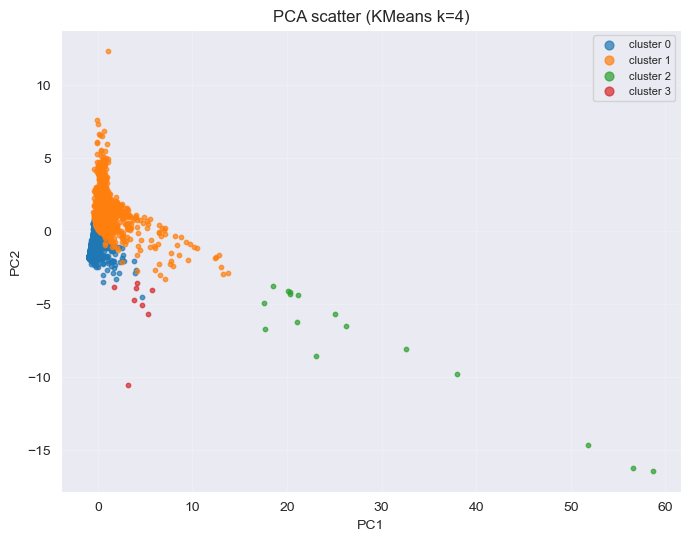

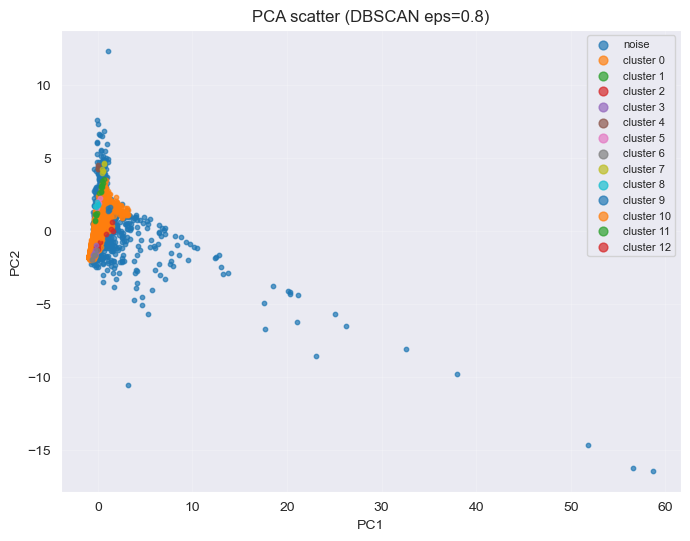

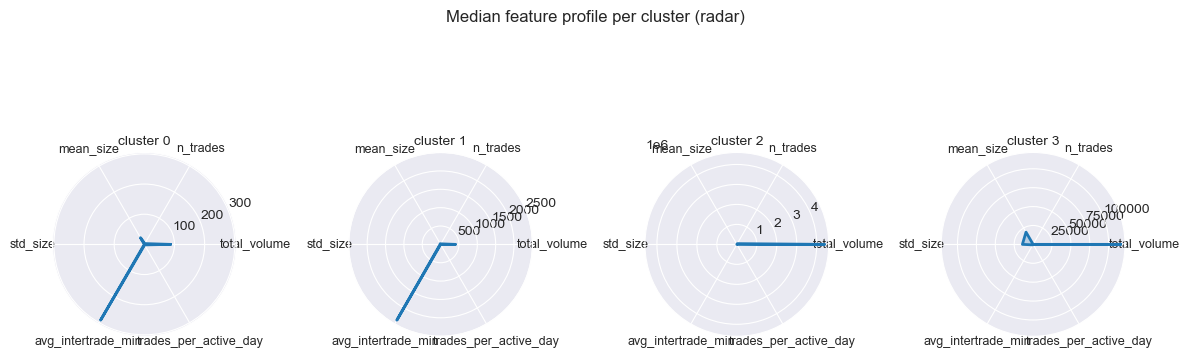

In [24]:
df = df_all.rename({"time": "timestamp", "wallet_id": "wallet"}, axis=1)

# Run segmentation
results = segment_wallets(df, kmeans_k=4, dbscan_eps=0.8, dbscan_min_samples=4)

# Save wallet -> cluster mapping
wallet_clusters = results['kmeans']['labels'].rename('kmeans_cluster').to_frame().join(results['pca_coords'])
# wallet_clusters.to_csv('wallet_clusters_kmeans.csv')
# print('\nSaved wallet_clusters_kmeans.csv')


In [25]:
records = []
for cluster_i in range(4):
    records.append(wallet_stats[wallet_stats["wallet_id"].isin(wallet_clusters[wallet_clusters["kmeans_cluster"] == cluster_i].index)].mean())

pd.DataFrame(records)

,wallet_id,n_trades,nunique_sizes,total_volume,avg_size,std_size,size_p01,size_p10,size_p50,size_p90,size_p99,first_trade,last_trade,unique_dates,unique_date_hour,trades_per_day,volume_share,wallet_interactions,realized_profit
0,69887.019198,10.307339,5.483011,1.599802e+03,188.941605,80.918312,128.344025,134.435364,171.373795,256.734131,360.967896,2025-06-05 14:33:16.923616256+00:00,2025-06-08 18:53:00.467307008+00:00,2.158512,3.266225,5.204145,0.000003,7.705233,-60.589666
1,41333.300481,283.705529,109.470913,2.198039e+04,161.627441,137.958405,41.526638,54.859013,128.461258,298.983307,518.828247,2025-05-10 12:39:51.535350784+00:00,2025-06-21 18:32:22.711507712+00:00,13.625481,51.667067,11.480469,0.000116,44.786058,-21.414514
2,17732.000000,63983.875000,11575.687500,3.852381e+06,447.808441,780.908264,0.813125,1.909250,37.180935,1400.234863,3800.887207,2025-04-04 17:29:16.147298560+00:00,2025-07-14 13:09:11.367544832+00:00,93.562500,1921.687500,892.597600,0.023438,3194.687500,60499.861469
3,81067.571429,8.285714,7.428571,1.459390e+05,19748.119141,14566.247070,6587.916992,6961.410156,16615.435547,35196.167969,40631.980469,2025-06-04 08:53:31.756963328+00:00,2025-06-17 22:37:32.426650880+00:00,3.285714,5.285714,2.902381,0.000857,61.857143,-16982.408468


In [26]:
print(wallet_stats[wallet_stats["wallet_id"].isin(wallet_clusters[wallet_clusters["kmeans_cluster"] == 2].index)].sort_values("volume_share", ascending=False)["volume_share"].sum())
wallet_stats[wallet_stats["wallet_id"].isin(wallet_clusters[wallet_clusters["kmeans_cluster"] == 2].index)].sort_values("volume_share", ascending=False)

0.375


,wallet_id,n_trades,nunique_sizes,total_volume,avg_size,std_size,size_p01,size_p10,size_p50,size_p90,size_p99,first_trade,last_trade,unique_dates,unique_date_hour,trades_per_day,volume_share,wallet_interactions,realized_profit
58,161,139051,27262,9530737.000,68.541306,143.107941,0.42,0.760000,11.070000,208.220001,644.520020,2025-03-22 10:50:43.490273671+00:00,2025-07-27 08:44:59.437000+00:00,128,3015,1086.335938,0.058,6445,15999.614909
16,22,79578,22622,6973105.000,87.626038,140.404144,0.46,1.680000,51.680000,206.412964,613.329346,2025-03-22 10:59:38.449109120+00:00,2025-07-27 08:40:50.029000+00:00,128,2821,621.703125,0.043,4384,72056.734755
1939,13372,1067,663,6594980.500,6180.862793,10054.875000,1.00,12.077998,286.709991,20000.000000,49775.980469,2025-03-22 20:13:34.670003528+00:00,2025-07-10 00:47:01.426000+00:00,48,124,22.229167,0.040,260,265433.690781
134,534,39258,18798,5635417.000,143.548248,280.851501,0.47,1.100000,49.465000,377.969025,1390.262573,2025-03-22 10:52:22.010294410+00:00,2025-07-27 08:42:49.339000+00:00,128,2971,306.703125,0.034,3580,253447.596216
212,892,76675,19935,5206099.500,67.898262,136.579926,0.44,0.790000,12.800000,208.430069,682.580505,2025-03-22 10:50:50.769304873+00:00,2025-07-27 08:44:59.437000+00:00,128,2969,599.023438,0.032,4901,22243.953758
127,480,29159,15192,5008946.000,171.780441,334.470093,0.46,0.930000,40.369999,464.819672,1669.534546,2025-03-22 10:59:44.856651452+00:00,2025-07-27 08:12:40.521000+00:00,125,2640,233.272000,0.031,2974,71488.976770
387,1621,25035,11133,4919995.500,196.524689,971.533264,0.52,1.490000,38.770000,282.895996,4126.150879,2025-03-22 20:13:34.670003528+00:00,2025-07-23 19:34:01.899000+00:00,106,421,236.179245,0.030,1207,73863.714173
14,19,189043,15435,4486441.500,23.732386,42.587444,0.47,0.830000,10.000000,53.630001,203.330002,2025-03-22 10:50:23.731759790+00:00,2025-07-27 08:45:47.161000+00:00,128,3046,1476.898438,0.027,6453,63102.256114
5,8,170994,15268,4276013.000,25.006802,44.284374,0.49,0.840000,11.140000,57.169998,210.770172,2025-03-22 10:50:22.930512310+00:00,2025-07-27 08:44:33.762000+00:00,128,3047,1335.890625,0.026,6014,-34561.040387
2749,19900,43563,13840,3187802.250,73.176826,142.088562,0.43,0.820000,13.270000,222.550003,651.285767,2025-03-22 11:44:42.963092632+00:00,2025-07-10 21:44:24.322000+00:00,101,2140,431.316832,0.019,3126,568.956422


# OLS description

In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Select predictors and target
X = wallet_stats[['n_trades', 'total_volume', 'avg_size', 'std_size']]
y = wallet_stats['realized_profit']

# Standardize predictors and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Fit OLS with standardized data
X_scaled = sm.add_constant(X_scaled)  # keep intercept
model_std = sm.OLS(y_scaled, X_scaled).fit()

print(model_std.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     118.5
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           5.71e-99
Time:                        10:46:20   Log-Likelihood:                -14056.
No. Observations:               10069   AIC:                         2.812e+04
Df Residuals:                   10064   BIC:                         2.816e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.925e-17      0.010  -4.03e-15      1.0

# corelation matrix

In [28]:
import pandas as pd

# Select numeric behavioral features
features = [
    'n_trades', 'nunique_sizes', 'total_volume', 'avg_size', 'std_size',
    'size_p01', 'size_p10', 'size_p50', 'size_p90', 'size_p99',
    'unique_dates', 'unique_date_hour', 'trades_per_day', 'volume_share', 'realized_profit',
    'wallet_interactions'
]

# Compute correlation matrices
corr_pearson = wallet_stats[features].corr(method='pearson')
corr_spearman = wallet_stats[features].corr(method='spearman')

# print("Pearson correlation:\n", corr_pearson, "\n")
# print("Spearman correlation:\n", corr_spearman)


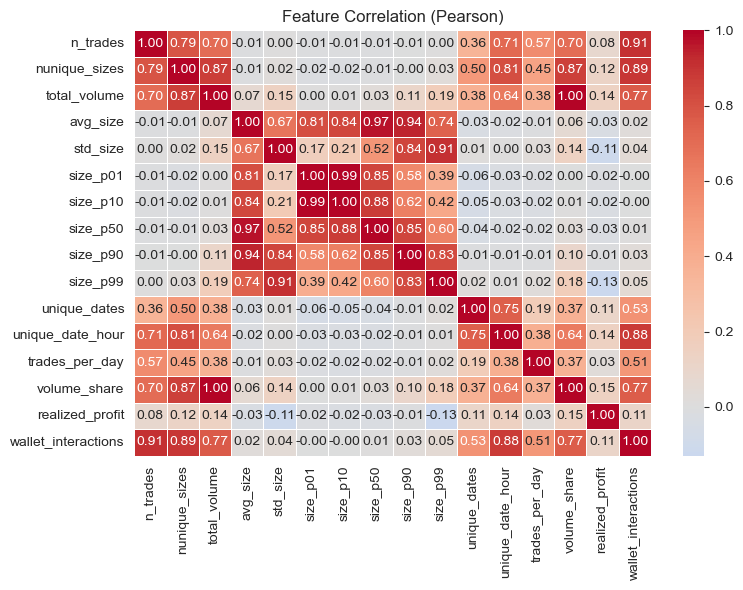

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_pearson,
            annot=True,       # show correlation values
            cmap='coolwarm',  # color gradient
            center=0,         # white = no correlation
            linewidths=0.5,
            fmt=".2f")

plt.title("Feature Correlation (Pearson)")
plt.tight_layout()
plt.show()


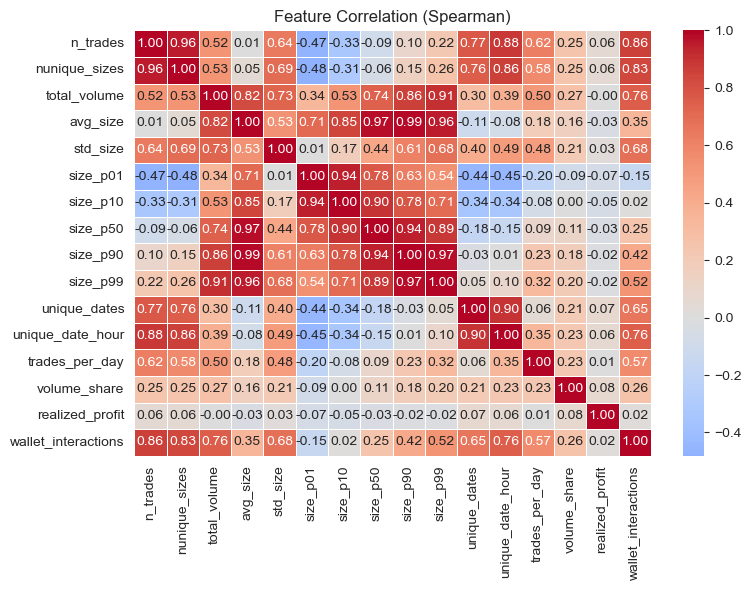

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_spearman,
            annot=True,       # show correlation values
            cmap='coolwarm',  # color gradient
            center=0,         # white = no correlation
            linewidths=0.5,
            fmt=".2f")

plt.title("Feature Correlation (Spearman)")
plt.tight_layout()
plt.show()


# correlation btw user stats and overall stats

In [31]:
import pandas as pd

# User-level daily volume
user_daily = (
    df_all
    .groupby(['wallet_id', 'date'], as_index=False)
    .agg(user_volume=('size', 'sum'))
)
user_daily.head()


,wallet_id,date,user_volume
0,1,2025-06-30,2305.679932
1,1,2025-07-01,2494.320068
2,3,2025-05-21,29047.890625
3,3,2025-05-22,17113.439453
4,3,2025-05-23,35615.250000


In [32]:
market_daily = (
    df_all
    .groupby('date', as_index=False)
    .agg(
        total_volume=('size', 'sum'),
        price_min=('price', 'min'),
        price_max=('price', 'max')
    )
)
market_daily['price_change'] = market_daily['price_max'] - market_daily['price_min']
market_daily.head()

,date,total_volume,price_min,price_max,price_change
0,2025-03-22,3.384315e+05,19.257999,19.770000,0.512001
1,2025-03-23,5.277593e+05,19.297001,19.832001,0.535000
2,2025-03-24,1.724013e+06,19.785000,22.141001,2.356001
3,2025-03-25,1.789450e+06,21.284000,23.452000,2.167999
4,2025-03-26,1.101883e+06,21.812000,23.229000,1.417000


In [33]:
df_merged = pd.merge(user_daily, market_daily, on='date', how='left')
df_merged.head()


,wallet_id,date,user_volume,total_volume,price_min,price_max,price_change
0,1,2025-06-30,2305.679932,1009917.125,17.699646,18.878000,1.178354
1,1,2025-07-01,2494.320068,1137615.000,16.938000,18.049999,1.112000
2,3,2025-05-21,29047.890625,1354354.875,22.155001,23.830999,1.675999
3,3,2025-05-22,17113.439453,2312025.500,23.128000,25.483000,2.355000
4,3,2025-05-23,35615.250000,2584186.500,22.912001,26.025999,3.113998


In [34]:
from scipy.stats import spearmanr

corrs = []

for wallet, group in df_merged.groupby('wallet_id'):
    if len(group) > 3:  # require some data points
        r1, _ = spearmanr(group['user_volume'], group['total_volume'])
        r2, _ = spearmanr(group['user_volume'], group['price_change'])
        corrs.append({'wallet_id': wallet, 'corr_with_total': r1, 'corr_with_price': r2})

corrs_df = pd.DataFrame(corrs)
corrs_df


/tmp/ipykernel_16174/1439339032.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r1, _ = spearmanr(group['user_volume'], group['total_volume'])
/tmp/ipykernel_16174/1439339032.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r2, _ = spearmanr(group['user_volume'], group['price_change'])


,wallet_id,corr_with_total,corr_with_price
0,3,0.670014,0.631304
1,5,0.314750,0.315015
2,6,0.183358,0.074913
3,7,0.280037,0.034752
4,8,0.762532,0.499745
...,...,...,...
3858,214954,0.632456,0.210819
3859,216192,0.500000,-0.400000
3860,218881,-0.607143,0.107143
3861,221774,0.737865,0.737865


In [35]:
pd.merge(
    wallet_stats,
    corrs_df,
    on="wallet_id",
    how="left"
).sort_values("volume_share", ascending=False).head(25)

,wallet_id,n_trades,nunique_sizes,total_volume,avg_size,std_size,size_p01,size_p10,size_p50,size_p90,...,first_trade,last_trade,unique_dates,unique_date_hour,trades_per_day,volume_share,wallet_interactions,realized_profit,corr_with_total,corr_with_price
58,161,139051,27262,9530737.000,68.541306,143.107941,0.420000,0.760000,11.070000,208.220001,...,2025-03-22 10:50:43.490273671+00:00,2025-07-27 08:44:59.437000+00:00,128,3015,1086.335938,0.058,6445,15999.614909,0.846451,0.619807
16,22,79578,22622,6973105.000,87.626038,140.404144,0.460000,1.680000,51.680000,206.412964,...,2025-03-22 10:59:38.449109120+00:00,2025-07-27 08:40:50.029000+00:00,128,2821,621.703125,0.043,4384,72056.734755,0.476733,0.258739
1939,13372,1067,663,6594980.500,6180.862793,10054.875000,1.000000,12.077998,286.709991,20000.000000,...,2025-03-22 20:13:34.670003528+00:00,2025-07-10 00:47:01.426000+00:00,48,124,22.229167,0.040,260,265433.690781,0.498521,0.241850
134,534,39258,18798,5635417.000,143.548248,280.851501,0.470000,1.100000,49.465000,377.969025,...,2025-03-22 10:52:22.010294410+00:00,2025-07-27 08:42:49.339000+00:00,128,2971,306.703125,0.034,3580,253447.596216,0.747299,0.486529
212,892,76675,19935,5206099.500,67.898262,136.579926,0.440000,0.790000,12.800000,208.430069,...,2025-03-22 10:50:50.769304873+00:00,2025-07-27 08:44:59.437000+00:00,128,2969,599.023438,0.032,4901,22243.953758,0.834846,0.630496
127,480,29159,15192,5008946.000,171.780441,334.470093,0.460000,0.930000,40.369999,464.819672,...,2025-03-22 10:59:44.856651452+00:00,2025-07-27 08:12:40.521000+00:00,125,2640,233.272000,0.031,2974,71488.976770,0.854562,0.545972
387,1621,25035,11133,4919995.500,196.524689,971.533264,0.520000,1.490000,38.770000,282.895996,...,2025-03-22 20:13:34.670003528+00:00,2025-07-23 19:34:01.899000+00:00,106,421,236.179245,0.030,1207,73863.714173,0.547260,0.284224
14,19,189043,15435,4486441.500,23.732386,42.587444,0.470000,0.830000,10.000000,53.630001,...,2025-03-22 10:50:23.731759790+00:00,2025-07-27 08:45:47.161000+00:00,128,3046,1476.898438,0.027,6453,63102.256114,0.747225,0.474975
5,8,170994,15268,4276013.000,25.006802,44.284374,0.490000,0.840000,11.140000,57.169998,...,2025-03-22 10:50:22.930512310+00:00,2025-07-27 08:44:33.762000+00:00,128,3047,1335.890625,0.026,6014,-34561.040387,0.762532,0.499745
437,1844,3413,2263,4046746.000,1185.685913,1133.243164,0.720000,14.000000,978.119995,2818.850098,...,2025-03-22 20:13:34.670003528+00:00,2025-07-26 21:00:34.133000+00:00,123,1024,27.747967,0.025,745,140319.784529,0.819730,0.522787


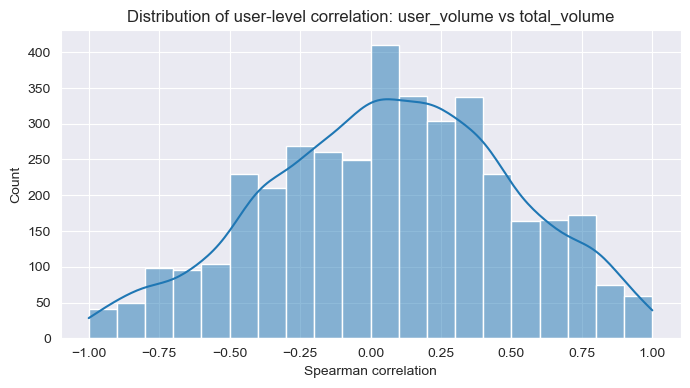

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.histplot(corrs_df['corr_with_total'], bins=20, kde=True)
plt.title("Distribution of user-level correlation: user_volume vs total_volume")
plt.xlabel("Spearman correlation")
plt.show()


In [37]:
wallet_stats.sort_values("volume_share", ascending=False).head(25)

,wallet_id,n_trades,nunique_sizes,total_volume,avg_size,std_size,size_p01,size_p10,size_p50,size_p90,size_p99,first_trade,last_trade,unique_dates,unique_date_hour,trades_per_day,volume_share,wallet_interactions,realized_profit
58,161,139051,27262,9530737.000,68.541306,143.107941,0.420000,0.760000,11.070000,208.220001,644.520020,2025-03-22 10:50:43.490273671+00:00,2025-07-27 08:44:59.437000+00:00,128,3015,1086.335938,0.058,6445,15999.614909
16,22,79578,22622,6973105.000,87.626038,140.404144,0.460000,1.680000,51.680000,206.412964,613.329346,2025-03-22 10:59:38.449109120+00:00,2025-07-27 08:40:50.029000+00:00,128,2821,621.703125,0.043,4384,72056.734755
1939,13372,1067,663,6594980.500,6180.862793,10054.875000,1.000000,12.077998,286.709991,20000.000000,49775.980469,2025-03-22 20:13:34.670003528+00:00,2025-07-10 00:47:01.426000+00:00,48,124,22.229167,0.040,260,265433.690781
134,534,39258,18798,5635417.000,143.548248,280.851501,0.470000,1.100000,49.465000,377.969025,1390.262573,2025-03-22 10:52:22.010294410+00:00,2025-07-27 08:42:49.339000+00:00,128,2971,306.703125,0.034,3580,253447.596216
212,892,76675,19935,5206099.500,67.898262,136.579926,0.440000,0.790000,12.800000,208.430069,682.580505,2025-03-22 10:50:50.769304873+00:00,2025-07-27 08:44:59.437000+00:00,128,2969,599.023438,0.032,4901,22243.953758
127,480,29159,15192,5008946.000,171.780441,334.470093,0.460000,0.930000,40.369999,464.819672,1669.534546,2025-03-22 10:59:44.856651452+00:00,2025-07-27 08:12:40.521000+00:00,125,2640,233.272000,0.031,2974,71488.976770
387,1621,25035,11133,4919995.500,196.524689,971.533264,0.520000,1.490000,38.770000,282.895996,4126.150879,2025-03-22 20:13:34.670003528+00:00,2025-07-23 19:34:01.899000+00:00,106,421,236.179245,0.030,1207,73863.714173
14,19,189043,15435,4486441.500,23.732386,42.587444,0.470000,0.830000,10.000000,53.630001,203.330002,2025-03-22 10:50:23.731759790+00:00,2025-07-27 08:45:47.161000+00:00,128,3046,1476.898438,0.027,6453,63102.256114
5,8,170994,15268,4276013.000,25.006802,44.284374,0.490000,0.840000,11.140000,57.169998,210.770172,2025-03-22 10:50:22.930512310+00:00,2025-07-27 08:44:33.762000+00:00,128,3047,1335.890625,0.026,6014,-34561.040387
437,1844,3413,2263,4046746.000,1185.685913,1133.243164,0.720000,14.000000,978.119995,2818.850098,3557.330078,2025-03-22 20:13:34.670003528+00:00,2025-07-26 21:00:34.133000+00:00,123,1024,27.747967,0.025,745,140319.784529


In [38]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Select predictors and target
X = wallet_stats.sort_values("volume_share", ascending=False).head(25)[['n_trades', 'avg_size', 'std_size']]
y = wallet_stats.sort_values("volume_share", ascending=False).head(25)['wallet_interactions']

# Standardize predictors and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Fit OLS with standardized data
X_train_scaled = sm.add_constant(X_scaled)  # keep intercept
model_std = sm.OLS(y_scaled, X_train_scaled).fit()

print(model_std.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     56.90
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           2.96e-10
Time:                        10:46:25   Log-Likelihood:                -7.8314
No. Observations:                  25   AIC:                             23.66
Df Residuals:                      21   BIC:                             28.54
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.18e-16      0.072  -1.63e-15      1.0

In [39]:
X_test_scaled = sm.add_constant(X_scaled, has_constant='add')
y_pred_scaled = model_std.predict(X_test_scaled)

# Convert predictions back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()


In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
# mape = np.mean(np.abs((y - y_pred) / scaler_y)) * 100  # optional

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")
# print(f"MAPE: {mape:.2f}%")


MAE:  595.3245
MSE:  452873.7448
RMSE: 672.9589
R²:   0.8904


In [41]:
((y.values - y_pred)/y.values)**2

array([9.58081717e-03, 1.82662300e-02, 5.62806205e+00, 1.08798246e-01,
       6.07154214e-02, 9.70208159e-02, 2.52560231e-01, 2.78336097e-02,
       2.24642127e-02, 1.68908259e-01, 2.39431307e-02, 3.20664946e-02,
       9.66690286e-01, 2.92303829e-02, 1.09599404e+01, 1.35705096e+00,
       2.29134838e-01, 5.46299991e+00, 5.54470398e-02, 5.79720124e+00,
       2.82613457e-02, 4.00000951e-03, 2.05987285e-02, 1.99297146e-01,
       4.21996783e-01])

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_wallet_balance(df, wallet_id, start_date_str, n_days=7, shift_days=0):
    """
    Plot accumulated token balance for a wallet over a specific time window,
    keeping balance constant between trades (step-like timeline).
    """

    # Ensure time column is timezone-aware
    df['time'] = pd.to_datetime(df['time'], utc=True)

    # Define date window
    start_date = pd.to_datetime(start_date_str, utc=True) + pd.Timedelta(days=shift_days)
    end_date = start_date + pd.Timedelta(days=n_days)

    # Filter for wallet and date range
    mask = (df['wallet_id'] == wallet_id) & (df['time'].between(start_date, end_date))
    df_wallet = df.loc[mask].copy()

    if df_wallet.empty:
        print(f"No data found for wallet {wallet_id} between {start_date.date()} and {end_date.date()}.")
        return

    # Sort by time
    df_wallet = df_wallet.sort_values('time')

    # Compute signed size and cumulative balance
    df_wallet['signed_size'] = np.where(df_wallet['is_ask'], -df_wallet['size'], df_wallet['size'])
    df_wallet['balance'] = df_wallet['signed_size'].cumsum()

    # Add previous balance at start and fill forward to create step plot
    df_wallet = pd.concat([
        pd.DataFrame({'time': [start_date], 'balance': [0]}),
        df_wallet[['time', 'balance']]
    ]).sort_values('time')

    # Fill forward to show constant balance between trades
    df_wallet['balance'] = df_wallet['balance'].ffill()

    # Add last point to extend flat line to end_date
    df_wallet = pd.concat([
        df_wallet,
        pd.DataFrame({'time': [end_date], 'balance': [df_wallet['balance'].iloc[-1]]})
    ])

    # Plot as a step plot
    plt.figure(figsize=(10, 5))
    plt.step(df_wallet['time'], df_wallet['balance'], where='post', linewidth=2)
    plt.scatter(df_wallet['time'], df_wallet['balance'], color='black', s=20, zorder=3)
    plt.title(f"Token Balance Over Time (Step Plot)\nWallet: {wallet_id}\n{start_date.date()} → {end_date.date()}")
    plt.xlabel("Time")
    plt.ylabel("Token Balance")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return df_wallet

In [43]:
i = 0

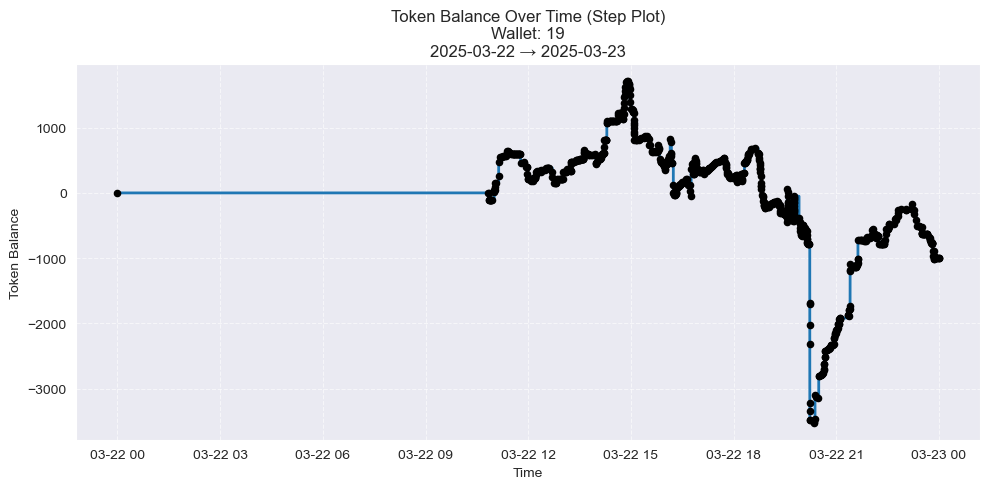

In [44]:
df_wallet = plot_wallet_balance(df_all, 19, "2025-03-22", n_days=1, shift_days=10*i)
i+=1

In [45]:
df_wallet.iloc[:40]

,time,balance
0,2025-03-22 00:00:00+00:00,0.000000
210628,2025-03-22 10:50:23.731759790+00:00,-1.000000
210629,2025-03-22 10:50:44.892815666+00:00,0.460000
210630,2025-03-22 10:50:50.769304873+00:00,-111.270004
210631,2025-03-22 10:51:26.271032954+00:00,-110.480003
210632,2025-03-22 10:52:22.010294410+00:00,-112.340004
210633,2025-03-22 10:52:30.055460271+00:00,-111.430000
210634,2025-03-22 10:52:39.523892372+00:00,-112.389999
210635,2025-03-22 10:54:44.776076618+00:00,-110.970001
210636,2025-03-22 10:54:53.484138673+00:00,-110.099998


In [46]:
wallet_stats[wallet_stats["wallet_id"] == 19]

,wallet_id,n_trades,nunique_sizes,total_volume,avg_size,std_size,size_p01,size_p10,size_p50,size_p90,size_p99,first_trade,last_trade,unique_dates,unique_date_hour,trades_per_day,volume_share,wallet_interactions,realized_profit
14,19,189043,15435,4486441.5,23.732386,42.587444,0.47,0.83,10.0,53.630001,203.330002,2025-03-22 10:50:23.731759790+00:00,2025-07-27 08:45:47.161000+00:00,128,3046,1476.898438,0.027,6453,63102.256114


In [47]:
wallet_stats

,wallet_id,n_trades,nunique_sizes,total_volume,avg_size,std_size,size_p01,size_p10,size_p50,size_p90,size_p99,first_trade,last_trade,unique_dates,unique_date_hour,trades_per_day,volume_share,wallet_interactions,realized_profit
0,1,69,5,4800.000,69.565216,285.302948,4.960000,4.960000,47.049999,47.060001,800.000061,2025-06-30 19:16:16.060000+00:00,2025-07-01 19:47:22.660000+00:00,2,4,34.500000,0.000,23,-2267.187876
1,3,3937,3222,711997.875,180.847824,273.010529,0.560000,3.926000,84.989998,475.785980,1323.202148,2025-05-21 14:47:25.050388950+00:00,2025-07-27 06:14:00.468000+00:00,66,711,59.651515,0.004,548,5735.945456
2,5,2156,1251,101469.781,47.063908,51.910038,1.529000,3.000000,23.395000,142.975006,170.933502,2025-03-22 10:59:45.086918079+00:00,2025-07-27 08:12:39.634000+00:00,67,476,32.179104,0.001,352,286.573061
3,6,3275,1653,160148.188,48.900211,56.465569,2.000000,3.000000,19.040001,152.991989,181.770004,2025-03-22 20:19:39.015273065+00:00,2025-07-14 05:57:35.749000+00:00,97,635,33.762887,0.001,330,-988.369196
4,7,5523,2245,216830.234,39.259502,51.657661,2.052200,3.000000,12.320000,138.825958,171.993408,2025-03-22 14:57:02.904875645+00:00,2025-07-27 05:03:12.884000+00:00,121,1125,45.644628,0.001,519,2080.928196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10064,271551,2,1,72.260,36.129997,0.000003,36.129997,36.129997,36.129997,36.130001,36.130001,2025-07-18 05:51:15.729000+00:00,2025-07-18 15:19:15.605000+00:00,1,2,2.000000,0.000,3,-47.005079
10065,271895,12,10,637.720,53.143337,18.827892,31.775200,35.654999,50.514999,75.479996,92.380806,2025-06-22 06:15:44.332000+00:00,2025-06-23 11:27:30.520000+00:00,2,7,6.000000,0.000,10,88.391194
10066,272337,2,1,119.320,59.660004,0.000003,59.660000,59.660000,59.660004,59.660004,59.660004,2025-06-22 09:22:01.823000+00:00,2025-06-23 06:18:48.518000+00:00,2,2,1.000000,0.000,3,4.533945
10067,272404,2,1,1919.800,959.900024,0.000000,959.900024,959.900024,959.900024,959.900024,959.900024,2025-06-23 16:40:53.219000+00:00,2025-06-23 16:45:39.769000+00:00,1,1,2.000000,0.000,15,-89.357148


# Interaction between wallets

In [48]:
df_interaction_1 = df_all_matched[["seller", "buyer", "size"]].rename({"buyer": "wallet_1", "seller": "wallet_2"}, axis=1).groupby(["wallet_1", "wallet_2"]).agg({"size": ["count", "sum"]}).reset_index()
df_interaction_1.columns = ["wallet_1", "wallet_2", "count", "size_sum"]

df_interaction_2 = df_all_matched[["seller", "buyer", "size"]].rename({"seller": "wallet_1", "buyer": "wallet_2"}, axis=1).groupby(["wallet_1", "wallet_2"]).agg({"size": ["count", "sum"]}).reset_index()
df_interaction_2.columns = ["wallet_1", "wallet_2", "count", "size_sum"]

In [49]:
interaction_df =(
    pd.concat([
        df_interaction_1,
        df_interaction_2
    ])
)
interaction_df = interaction_df.groupby(["wallet_1", "wallet_2"]).sum().reset_index()
interaction_df

,wallet_1,wallet_2,count,size_sum
0,1,8,10,391.039978
1,1,19,15,476.010010
2,1,20,2,9.930000
3,1,22,4,197.790009
4,1,34,1,55.419998
...,...,...,...,...
284191,272404,625,1,23.000000
284192,272404,1270,1,346.640015
284193,274311,19,1,2.710000
284194,274311,480,1,2.710000


In [50]:
overall_volume = interaction_df.groupby("wallet_1")["size_sum"].sum().reset_index().rename({"size_sum": "overall_volume"}, axis=1)
interaction_df = interaction_df.merge(overall_volume, how="left", on="wallet_1")

overall_volume = interaction_df.groupby("wallet_1")["count"].sum().reset_index().rename({"count": "overall_count"}, axis=1)
interaction_df = interaction_df.merge(overall_volume, how="left", on="wallet_1")
interaction_df

,wallet_1,wallet_2,count,size_sum,overall_volume,overall_count
0,1,8,10,391.039978,4800.000000,111
1,1,19,15,476.010010,4800.000000,111
2,1,20,2,9.930000,4800.000000,111
3,1,22,4,197.790009,4800.000000,111
4,1,34,1,55.419998,4800.000000,111
...,...,...,...,...,...,...
284191,272404,625,1,23.000000,1919.800049,25
284192,272404,1270,1,346.640015,1919.800049,25
284193,274311,19,1,2.710000,5.420000,2
284194,274311,480,1,2.710000,5.420000,2


In [51]:
interaction_df["volume_share"] = interaction_df["size_sum"] / interaction_df["overall_volume"]
interaction_df["count_share"] = interaction_df["count"] / interaction_df["overall_count"]
interaction_df

,wallet_1,wallet_2,count,size_sum,overall_volume,overall_count,volume_share,count_share
0,1,8,10,391.039978,4800.000000,111,0.081467,0.090090
1,1,19,15,476.010010,4800.000000,111,0.099169,0.135135
2,1,20,2,9.930000,4800.000000,111,0.002069,0.018018
3,1,22,4,197.790009,4800.000000,111,0.041206,0.036036
4,1,34,1,55.419998,4800.000000,111,0.011546,0.009009
...,...,...,...,...,...,...,...,...
284191,272404,625,1,23.000000,1919.800049,25,0.011980,0.040000
284192,272404,1270,1,346.640015,1919.800049,25,0.180560,0.040000
284193,274311,19,1,2.710000,5.420000,2,0.500000,0.500000
284194,274311,480,1,2.710000,5.420000,2,0.500000,0.500000


In [52]:
interaction_df[interaction_df["wallet_1"].isin(interaction_df["wallet_1"].unique()[22:])].sort_values(["overall_volume", "volume_share"], ascending=False)

,wallet_1,wallet_2,count,size_sum,overall_volume,overall_count,volume_share,count_share
56506,161,892,2667,672277.250000,9530737.00,160441,0.070538,0.016623
56328,161,22,6747,665120.000000,9530737.00,160441,0.069787,0.042053
56317,161,8,15477,386745.812500,9530737.00,160441,0.040579,0.096465
56326,161,19,14853,368004.656250,9530737.00,160441,0.038612,0.092576
58312,161,19900,790,258478.296875,9530737.00,160441,0.027120,0.004924
...,...,...,...,...,...,...,...,...
237227,46722,37,1,0.010000,0.02,2,0.500000,0.500000
237228,46722,161,1,0.010000,0.02,2,0.500000,0.500000
283109,213204,19,1,0.010000,0.02,2,0.500000,0.500000
283110,213204,88,1,0.010000,0.02,2,0.500000,0.500000


In [53]:
interaction_df[(
        (interaction_df["wallet_1"] == 1844 ) & (interaction_df["wallet_2"] == 13372) |
        (interaction_df["wallet_1"] == 21286) & (interaction_df["wallet_2"] == 13372) |
        (interaction_df["wallet_1"] == 4934	) & (interaction_df["wallet_2"] == 566	) |
        (interaction_df["wallet_1"] == 4934	) & (interaction_df["wallet_2"] == 534	) |
        (interaction_df["wallet_1"] == 4934	) & (interaction_df["wallet_2"] == 1844	) |
        (interaction_df["wallet_1"] == 62   ) & (interaction_df["wallet_2"] == 13372)
)]

,wallet_1,wallet_2,count,size_sum,overall_volume,overall_count,volume_share,count_share
41813,62,13372,453,261684.593750,1557029.125,7852,0.168067,0.057692
124553,1844,13372,336,860406.062500,4046746.000,4239,0.212617,0.079264
136244,4934,534,402,184966.531250,1588673.250,6283,0.116428,0.063982
136245,4934,566,271,206730.140625,1588673.250,6283,0.130128,0.043132
136278,4934,1844,85,181208.625000,1588673.250,6283,0.114063,0.013529
193850,21286,13372,45,377943.812500,2174868.250,14387,0.173778,0.003128


In [54]:
interaction_df[(
        (interaction_df["wallet_1"] == 13372 )
    )].sort_values(["overall_volume", "count_share"], ascending=False)

,wallet_1,wallet_2,count,size_sum,overall_volume,overall_count,volume_share,count_share
161023,13372,22,3409,171707.687500,6594980.5,22526,2.603612e-02,0.151336
161014,13372,8,1153,74997.453125,6594980.5,22526,1.137190e-02,0.051185
161021,13372,19,1108,70712.984375,6594980.5,22526,1.072224e-02,0.049188
161085,13372,480,1017,327243.718750,6594980.5,22526,4.962012e-02,0.045148
161028,13372,29,944,137174.546875,6594980.5,22526,2.079984e-02,0.041907
...,...,...,...,...,...,...,...,...
161261,13372,49866,1,0.970000,6594980.5,22526,1.470816e-07,0.000044
161263,13372,50229,1,1446.959961,6594980.5,22526,2.194032e-04,0.000044
161266,13372,53811,1,7.850000,6594980.5,22526,1.190299e-06,0.000044
161268,13372,77670,1,74.739998,6594980.5,22526,1.133286e-05,0.000044


In [55]:
interaction_df[(interaction_df["overall_count"] > 100) & (interaction_df["count_share"] > 0.3)].sort_values(["overall_volume", "count_share"], ascending=False)

,wallet_1,wallet_2,count,size_sum,overall_volume,overall_count,volume_share,count_share
140060,5618,13372,205,60894.320312,173943.531250,680,0.350081,0.301471
245580,50152,22,94,9257.320312,48605.070312,284,0.190460,0.330986
174259,18373,22,136,12327.549805,48600.000000,400,0.253653,0.340000
8294,11,22,261,26302.240234,44990.660156,557,0.584616,0.468582
146989,7806,22,206,11055.660156,42773.757812,636,0.258468,0.323899
246639,50323,22,195,13691.630859,33493.691406,389,0.408782,0.501285
142217,6026,22,43,5907.750000,33466.582031,138,0.176527,0.311594
213310,30098,22,78,7493.669922,31424.199219,210,0.238468,0.371429
161864,13556,22,95,11382.349609,30611.589844,187,0.371831,0.508021
258281,59491,22,129,11280.389648,28885.890625,255,0.390516,0.505882


In [56]:
df_all_matched[df_all_matched["seller"].isin([5618, 13372]) & df_all_matched["buyer"].isin([5618, 13372])].iloc[72:78]

,price,size,time,seller,buyer
427927,20.922001,287.100006,2025-04-30 15:34:14.234587202,5618,13372
428027,20.972000,287.100006,2025-04-30 15:34:43.258561936,5618,13372
428116,21.020000,287.100006,2025-04-30 15:34:59.526485466,5618,13372
431271,20.857000,287.000000,2025-04-30 22:43:32.791990395,13372,5618
431323,20.844000,287.000000,2025-04-30 22:43:41.376190230,13372,5618
431402,20.829000,287.000000,2025-04-30 22:43:54.098710929,13372,5618


In [57]:
dfc = df_all_matched[df_all_matched["time"].isin(t)]

NameError: name 't' is not defined

In [79]:
dfc["cumsum"] = dfc["size"].cumsum()

/tmp/ipykernel_6843/1041400191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc["cumsum"] = dfc["size"].cumsum()


# UNNECESSARY

In [119]:
wallet_id = 82

In [120]:
i = 0

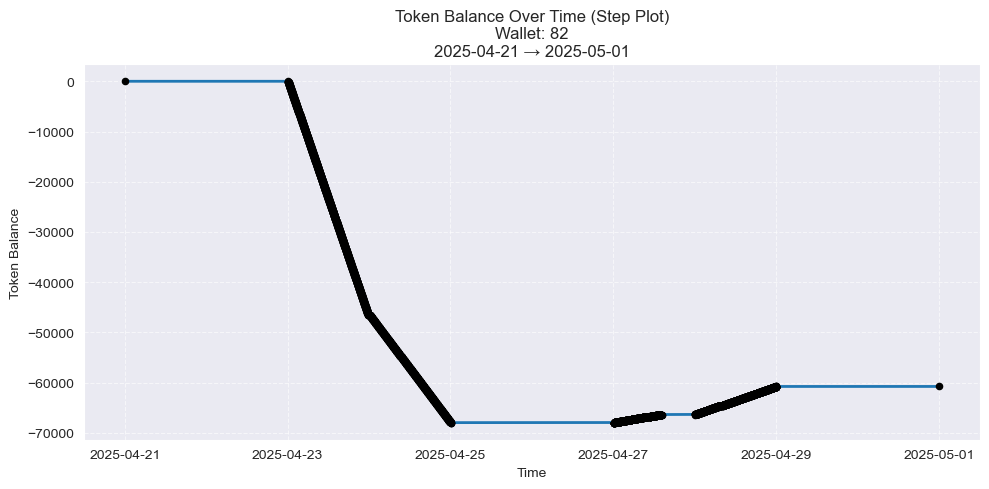

In [124]:
df_wallet = plot_wallet_balance(df_all, wallet_id, "2025-03-22", n_days=10, shift_days=10*i)
i+=1

In [109]:
df_wallet

,time,balance
0,2025-03-22 00:00:00+00:00,0.000000
1728270,2025-03-29 07:13:32.240446365+00:00,-32.000000
1728271,2025-03-29 07:13:33.937788273+00:00,-71.150002
1728272,2025-03-29 07:13:34.453859191+00:00,-85.330002
1728273,2025-03-29 07:13:35.017427099+00:00,-138.660004
...,...,...
1728528,2025-03-31 06:31:23.599269630+00:00,-68.079979
1728529,2025-03-31 06:31:29.873119560+00:00,-67.429977
1728530,2025-03-31 06:31:35.605105350+00:00,-66.779976
1728531,2025-03-31 06:31:39.975860117+00:00,-65.599976


In [68]:
wallet_stats[wallet_stats["wallet_id"] == wallet_id]

,wallet_id,n_trades,nunique_sizes,total_volume,avg_size,std_size,size_p01,size_p10,size_p50,size_p90,size_p99,first_trade,last_trade,unique_dates,unique_date_hour,trades_per_day,volume_share,wallet_interactions,realized_profit
4784,36251,3,3,11254.279,3751.426514,2360.196045,1169.809937,1786.219971,4525.819824,5406.875977,5605.11377,2025-05-22 10:02:52.391679724+00:00,2025-05-22 10:27:40.388735157+00:00,1,1,3.0,0.0,23,-699.405646


In [118]:
interaction_df[interaction_df["wallet_1"] == wallet_id].sort_values("count_share", ascending=False)

,wallet_1,wallet_2,count,size_sum,overall_volume,overall_count,volume_share,count_share
163561,14468,161,3616,32028.441406,301350.53125,40288,0.106283,0.089754
163528,14468,19,3584,23704.750000,301350.53125,40288,0.078662,0.088959
163521,14468,8,2789,17094.289062,301350.53125,40288,0.056726,0.069227
163551,14468,88,2573,16221.700195,301350.53125,40288,0.053830,0.063865
163530,14468,22,2156,21308.689453,301350.53125,40288,0.070711,0.053515
...,...,...,...,...,...,...,...,...
163971,14468,59388,1,5.000000,301350.53125,40288,0.000017,0.000025
163977,14468,65902,1,3.260000,301350.53125,40288,0.000011,0.000025
163980,14468,75670,1,2.450000,301350.53125,40288,0.000008,0.000025
163997,14468,205138,1,12.200000,301350.53125,40288,0.000040,0.000025


In [ ]:
226, 34188